# Stock Prices Time Series Forecasting

This notebook demonstrates a full workflow for time series forecasting using stock market data.

1. Import Libraries
2. Initialization and Data Fetching
3. Model Fitting Methods
4. Forecasting Methods
5. Evaluate and visualize model performances
6. Visualization Methods
7. Initializing and Configuring the Forecaster
8. Fetch Stock Data
9. Generating Forecasts
10. Display Results and Summary
11. Visualizing Forecasts
12. Additional Analysis

### 1. Import Libraries

In [47]:
import pandas as pd
import numpy as np
import yfinance as yf
from datetime import datetime, timedelta
import warnings
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns

# Suppress the warnings
warnings.filterwarnings('ignore')

## 2. Initialization and Data Fetching

In [48]:
class StockForecaster:
    """
    A comprehensive stock forecasting class that handles time series data properly
    and provides multiple forecasting methods.
    """

    def __init__(self, symbols, period='2y', forecast_days=30):
        """
        Initialize the forecaster with stock symbols and parameters.

        Parameters:
        -----------
        symbols : list
            List of stock symbols to forecast
        period : str
            Data period to fetch (e.g., '1y', '2y', '5y')
        forecast_days : int
            Number of days to forecast ahead
        """
        self.symbols = symbols
        self.period = period
        self.forecast_days = forecast_days
        self.data = {}
        self.forecasts = {}
        self.models = {}

    def fetch_data(self):
        """Fetch stock data with proper date indexing."""
        print("Fetching stock data...")

        for symbol in self.symbols:
            try:
                # Fetching data using yfinance
                stock = yf.Ticker(symbol)
                hist_data = stock.history(period=self.period)

                if hist_data.empty:
                    print(f"Warning: No data found for {symbol}")
                    continue

                # Ensuring proper date index with frequency
                hist_data.index = pd.to_datetime(hist_data.index)
                hist_data = hist_data.asfreq('D', method='ffill')  # Daily frequency

                # Calculating daily returns
                hist_data['Returns'] = hist_data['Close'].pct_change()
                hist_data = hist_data.dropna()

                self.data[symbol] = hist_data
                print(f"✓ Successfully fetched {len(hist_data)} days of data for {symbol}")

            except Exception as e:
                print(f"✗ Error fetching data for {symbol}: {str(e)}")

    def prepare_time_series(self, symbol, column='Close'):
        """
        Prepare time series data with proper frequency and stationarity checks.

        Parameters:
        -----------
        symbol : str
            Stock symbol
        column : str
            Column to use for forecasting

        Returns:
        --------
        pd.Series
            Properly formatted time series
        """
        if symbol not in self.data:
            raise ValueError(f"No data available for {symbol}")

        ts = self.data[symbol][column].copy()

        ts = ts.dropna()

        # Setting frequency explicitly
        ts.index = pd.DatetimeIndex(ts.index, freq='D')

        return ts

print("StockForecaster class defined successfully!")

StockForecaster class defined successfully!


## 3. Model Fitting Methods

In [50]:
def fit_arima_model(self, symbol, order=(1, 1, 1)):
    """
    Fit ARIMA model with proper error handling.

    Parameters:
    -----------
    symbol : str
        Stock symbol
    order : tuple
        ARIMA order (p, d, q)

    Returns:
    --------
    fitted model or None
    """
    try:
        ts = self.prepare_time_series(symbol)

        # Fitting ARIMA model
        model = ARIMA(ts, order=order, freq='D')
        fitted_model = model.fit()

        return fitted_model

    except Exception as e:
        print(f"Error fitting ARIMA model for {symbol}: {str(e)}")
        return None

def fit_exponential_smoothing(self, symbol):
    """
    Fit Exponential Smoothing model.

    Parameters:
    -----------
    symbol : str
        Stock symbol

    Returns:
    --------
    fitted model or None
    """
    try:
        ts = self.prepare_time_series(symbol)

        # Fitting Exponential Smoothing model
        model = ExponentialSmoothing(
            ts,
            trend='add',
            seasonal=None,
            freq='D'
        )
        fitted_model = model.fit()

        return fitted_model

    except Exception as e:
        print(f"Error fitting Exponential Smoothing model for {symbol}: {str(e)}")
        return None

# Adding methods to the class
StockForecaster.fit_arima_model = fit_arima_model
StockForecaster.fit_exponential_smoothing = fit_exponential_smoothing

print("Model fitting methods added successfully!")

Model fitting methods added successfully!


## 4. Forecasting Methods

In [51]:
def generate_forecasts(self, method='arima'):
    """
    Generate forecasts for all symbols.

    Parameters:
    -----------
    method : str
        Forecasting method ('arima', 'exp_smoothing', 'ensemble')
    """
    print(f"\nGenerating forecasts using {method} method...")

    for symbol in self.symbols:
        if symbol not in self.data:
            continue

        try:
            current_price = self.data[symbol]['Close'].iloc[-1]

            if method == 'arima':
                model = self.fit_arima_model(symbol)
                if model is not None:
                    forecast = model.forecast(steps=self.forecast_days)
                    forecast_index = pd.date_range(
                        start=self.data[symbol].index[-1] + timedelta(days=1),
                        periods=self.forecast_days,
                        freq='D'
                    )
                    forecast_series = pd.Series(forecast, index=forecast_index)

            elif method == 'exp_smoothing':
                model = self.fit_exponential_smoothing(symbol)
                if model is not None:
                    forecast = model.forecast(steps=self.forecast_days)
                    forecast_index = pd.date_range(
                        start=self.data[symbol].index[-1] + timedelta(days=1),
                        periods=self.forecast_days,
                        freq='D'
                    )
                    forecast_series = pd.Series(forecast, index=forecast_index)

            elif method == 'ensemble':
                # Using ensemble of both methods
                arima_model = self.fit_arima_model(symbol)
                exp_model = self.fit_exponential_smoothing(symbol)

                if arima_model is not None and exp_model is not None:
                    arima_forecast = arima_model.forecast(steps=self.forecast_days)
                    exp_forecast = exp_model.forecast(steps=self.forecast_days)

                    # Mean of the forecasts
                    ensemble_forecast = (arima_forecast + exp_forecast) / 2

                    forecast_index = pd.date_range(
                        start=self.data[symbol].index[-1] + timedelta(days=1),
                        periods=self.forecast_days,
                        freq='D'
                    )
                    forecast_series = pd.Series(ensemble_forecast, index=forecast_index)
                else:
                    continue

            # Calculating predicted return
            predicted_price = forecast_series.iloc[-1]
            predicted_return = ((predicted_price - current_price) / current_price) * 100

            self.forecasts[symbol] = {
                'current_price': current_price,
                'predicted_price': predicted_price,
                'predicted_return': predicted_return,
                'forecast_series': forecast_series
            }

            print(f"✓ {symbol}: {predicted_return:.2f}% predicted return")

        except Exception as e:
            print(f"✗ Error forecasting {symbol}: {str(e)}")

# Adding method to the class
StockForecaster.generate_forecasts = generate_forecasts

print("Forecasting methods added successfully!")

Forecasting methods added successfully!


## 5. Recommendations and Analysis

In [52]:
def get_recommendations(self, top_n=3):
    """
    Get top stock recommendations based on predicted returns.

    Parameters:
    -----------
    top_n : int
        Number of top recommendations to return

    Returns:
    --------
    pd.DataFrame
        Recommendations sorted by predicted return
    """
    if not self.forecasts:
        print("No forecasts available. Please run generate_forecasts() first.")
        return pd.DataFrame()

    # Creating recommendations DataFrame
    recommendations = []
    for symbol, forecast in self.forecasts.items():
        recommendations.append({
            'Symbol': symbol,
            'Current Price': forecast['current_price'],
            'Predicted Price': forecast['predicted_price'],
            'Predicted Return (%)': forecast['predicted_return']
        })

    df_recommendations = pd.DataFrame(recommendations)
    df_recommendations = df_recommendations.sort_values(
        'Predicted Return (%)', ascending=False
    ).head(top_n)

    return df_recommendations

def print_summary(self):
    """Print a comprehensive summary of the forecasting results."""
    print("\n" + "="*60)
    print("STOCK FORECASTING SUMMARY")
    print("="*60)

    if not self.forecasts:
        print("No forecasts available.")
        return

    # Getting recommendations
    recommendations = self.get_recommendations(top_n=len(self.forecasts))

    print(f"\nTop Recommendations (by predicted % return):")
    print("-" * 50)
    for idx, row in recommendations.iterrows():
        symbol = row['Symbol']
        current = row['Current Price']
        predicted = row['Predicted Price']
        return_pct = row['Predicted Return (%)']

        print(f"{symbol:>6}: {return_pct:>7.2f}% "
              f"(${current:.2f} → ${predicted:.2f})")

    print("\nModel Performance Summary:")
    print("-" * 50)
    print(f"Total symbols analyzed: {len(self.data)}")
    print(f"Successful forecasts: {len(self.forecasts)}")
    print(f"Forecast horizon: {self.forecast_days} days")

# Adding methods to the class
StockForecaster.get_recommendations = get_recommendations
StockForecaster.print_summary = print_summary

print("Analysis methods added successfully!")

Analysis methods added successfully!


## 6. Visualization Methods

In [53]:
def plot_forecasts(self, symbols=None, figsize=(15, 10)):
    """
    Plot historical data and forecasts.

    Parameters:
    -----------
    symbols : list
        List of symbols to plot (default: all)
    figsize : tuple
        Figure size
    """
    if symbols is None:
        symbols = list(self.forecasts.keys())

    n_symbols = len(symbols)
    if n_symbols == 0:
        print("No forecasts to plot.")
        return

    n_rows = (n_symbols + 1) // 2
    n_cols = 2 if n_symbols > 1 else 1

    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=figsize)

    if n_symbols == 1:
        axes = [axes]
    elif n_symbols == 2:
        axes = axes if isinstance(axes, np.ndarray) else [axes]
    else:
        axes = axes.flatten() if isinstance(axes, np.ndarray) else [axes]

    for i, symbol in enumerate(symbols):
        if symbol not in self.forecasts:
            continue

        ax = axes[i]

        # Plotting historical data (last 90 days)
        historical_data = self.data[symbol]['Close'].tail(90)
        ax.plot(historical_data.index, historical_data.values,
               label='Historical', color='blue', linewidth=2)

        # Plotting forecast
        forecast_data = self.forecasts[symbol]['forecast_series']
        ax.plot(forecast_data.index, forecast_data.values,
               label='Forecast', color='red', linewidth=2, linestyle='--')

        # Adding current price line
        current_price = self.forecasts[symbol]['current_price']
        ax.axhline(y=current_price, color='green', linestyle=':',
                  label=f'Current: ${current_price:.2f}')

        # Formatting
        ax.set_title(f'{symbol} - Price Forecast', fontsize=14, fontweight='bold')
        ax.set_xlabel('Date', fontsize=12)
        ax.set_ylabel('Price ($)', fontsize=12)
        ax.legend(fontsize=10)
        ax.grid(True, alpha=0.3)

        plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)

    for i in range(n_symbols, len(axes)):
        axes[i].set_visible(False)

    plt.tight_layout()
    plt.show()

StockForecaster.plot_forecasts = plot_forecasts

print("Visualization methods added successfully!")

Visualization methods added successfully!


## 7. Initializing and Configuring the Forecaster

In [56]:
symbols = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'TSLA']

forecaster = StockForecaster(
    symbols=symbols,
    period='1y',        # 1 year of historical data
    forecast_days=30    # 30 days forecast
)

print(f"Symbols to analyze: {', '.join(symbols)}")
print(f"Historical period: {forecaster.period}")
print(f"Forecast horizon: {forecaster.forecast_days} days")

Symbols to analyze: AAPL, MSFT, GOOGL, AMZN, TSLA
Historical period: 1y
Forecast horizon: 30 days


## 8. Fetch Stock Data

In [57]:
forecaster.fetch_data()

print("\nSample data preview:")
print("-" * 50)
for symbol in forecaster.symbols:
    if symbol in forecaster.data:
        latest_data = forecaster.data[symbol].tail(1)
        print(f"{symbol}: Latest close price = ${latest_data['Close'].iloc[0]:.2f}")
        print(f"      Data range: {forecaster.data[symbol].index[0].strftime('%Y-%m-%d')} to {forecaster.data[symbol].index[-1].strftime('%Y-%m-%d')}")
        print()

print("Data fetching completed!")

Fetching stock data...
✓ Successfully fetched 363 days of data for AAPL
✓ Successfully fetched 363 days of data for MSFT
✓ Successfully fetched 363 days of data for GOOGL
✓ Successfully fetched 363 days of data for AMZN
✓ Successfully fetched 363 days of data for TSLA

Sample data preview:
--------------------------------------------------
AAPL: Latest close price = $213.55
      Data range: 2024-07-06 to 2025-07-03

MSFT: Latest close price = $498.84
      Data range: 2024-07-06 to 2025-07-03

GOOGL: Latest close price = $179.53
      Data range: 2024-07-06 to 2025-07-03

AMZN: Latest close price = $223.41
      Data range: 2024-07-06 to 2025-07-03

TSLA: Latest close price = $315.35
      Data range: 2024-07-06 to 2025-07-03

Data fetching completed!


## 9. Generating Forecasts

In [59]:
forecaster.generate_forecasts(method='ensemble')

# Alternative
# forecaster.generate_forecasts(method='arima')
# forecaster.generate_forecasts(method='exp_smoothing')

print("\n🔮 Forecasting completed!")
print(f"Successfully generated forecasts for {len(forecaster.forecasts)} symbols.")


Generating forecasts using ensemble method...
✓ AAPL: -0.22% predicted return
✓ MSFT: 0.26% predicted return
✓ GOOGL: -0.22% predicted return
✓ AMZN: 0.34% predicted return
✓ TSLA: 0.83% predicted return

🔮 Forecasting completed!
Successfully generated forecasts for 5 symbols.


## 10. Display Results and Summary

In [60]:
forecaster.print_summary()

print("\n" + "="*60)
print("DETAILED RECOMMENDATIONS")
print("="*60)

top_recommendations = forecaster.get_recommendations(top_n=len(forecaster.forecasts))
print(top_recommendations.round(2).to_string(index=False))

print("\n" + "="*60)
print("INDIVIDUAL FORECAST DETAILS")
print("="*60)

for symbol, forecast in forecaster.forecasts.items():
    print(f"\n{symbol}:")
    print(f"  Current Price: ${forecast['current_price']:.2f}")
    print(f"  Predicted Price (30 days): ${forecast['predicted_price']:.2f}")
    print(f"  Expected Return: {forecast['predicted_return']:.2f}%")

    # Risk assessment
    if forecast['predicted_return'] > 10:
        risk = "High Growth Potential"
    elif forecast['predicted_return'] > 5:
        risk = "Moderate Growth"
    elif forecast['predicted_return'] > 0:
        risk = "Slight Growth"
    else:
        risk = "Potential Decline"

    print(f"  Assessment: {risk}")
    print("-" * 30)


STOCK FORECASTING SUMMARY

Top Recommendations (by predicted % return):
--------------------------------------------------
  TSLA:    0.83% ($315.35 → $317.98)
  AMZN:    0.34% ($223.41 → $224.17)
  MSFT:    0.26% ($498.84 → $500.16)
  AAPL:   -0.22% ($213.55 → $213.07)
 GOOGL:   -0.22% ($179.53 → $179.13)

Model Performance Summary:
--------------------------------------------------
Total symbols analyzed: 5
Successful forecasts: 5
Forecast horizon: 30 days

DETAILED RECOMMENDATIONS
Symbol  Current Price  Predicted Price  Predicted Return (%)
  TSLA         315.35           317.98                  0.83
  AMZN         223.41           224.17                  0.34
  MSFT         498.84           500.16                  0.26
  AAPL         213.55           213.07                 -0.22
 GOOGL         179.53           179.13                 -0.22

INDIVIDUAL FORECAST DETAILS

AAPL:
  Current Price: $213.55
  Predicted Price (30 days): $213.07
  Expected Return: -0.22%
  Assessment: Potent

## 11. Visualizing Forecasts

📊 Generating forecast visualizations...


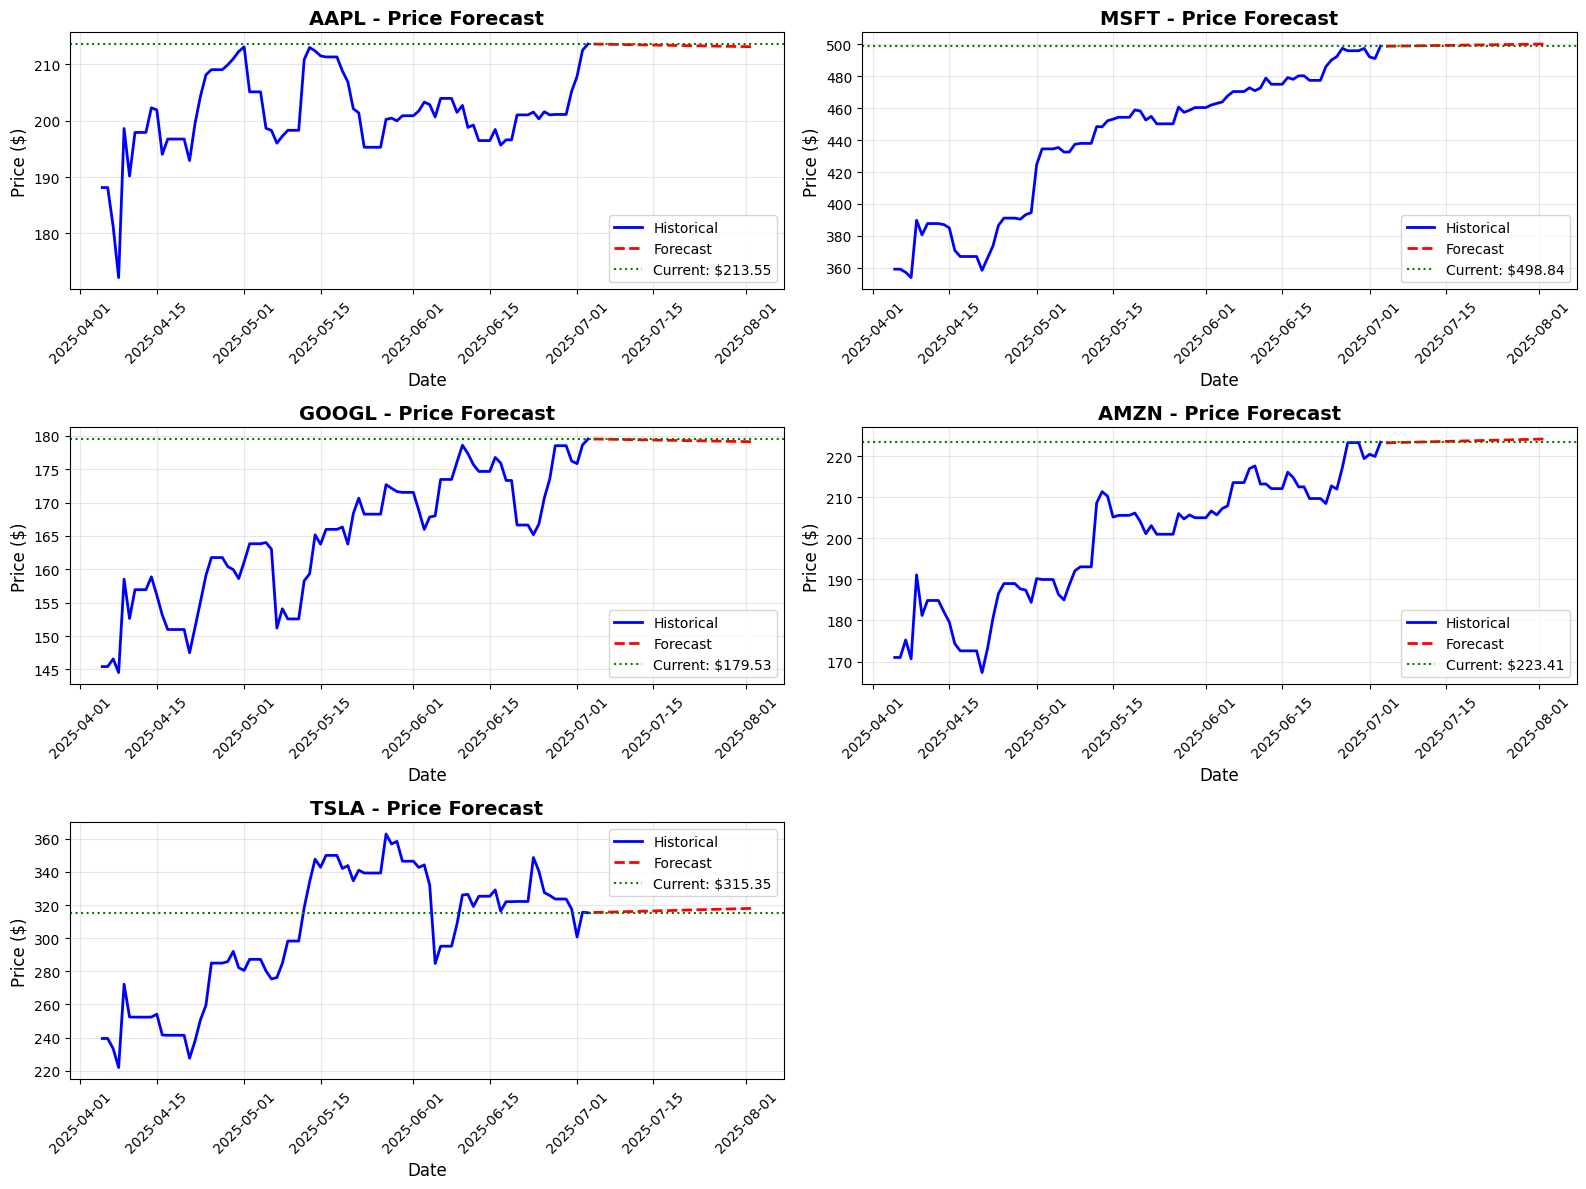

In [45]:
plt.style.use('default')
plt.rcParams['figure.dpi'] = 100

print("Generating forecast visualizations...")
forecaster.plot_forecasts(figsize=(16, 12))

# plot for specific symbols
# forecaster.plot_forecasts(symbols=['AAPL', 'TSLA'], figsize=(12, 6))

## 12. Additional Analysis

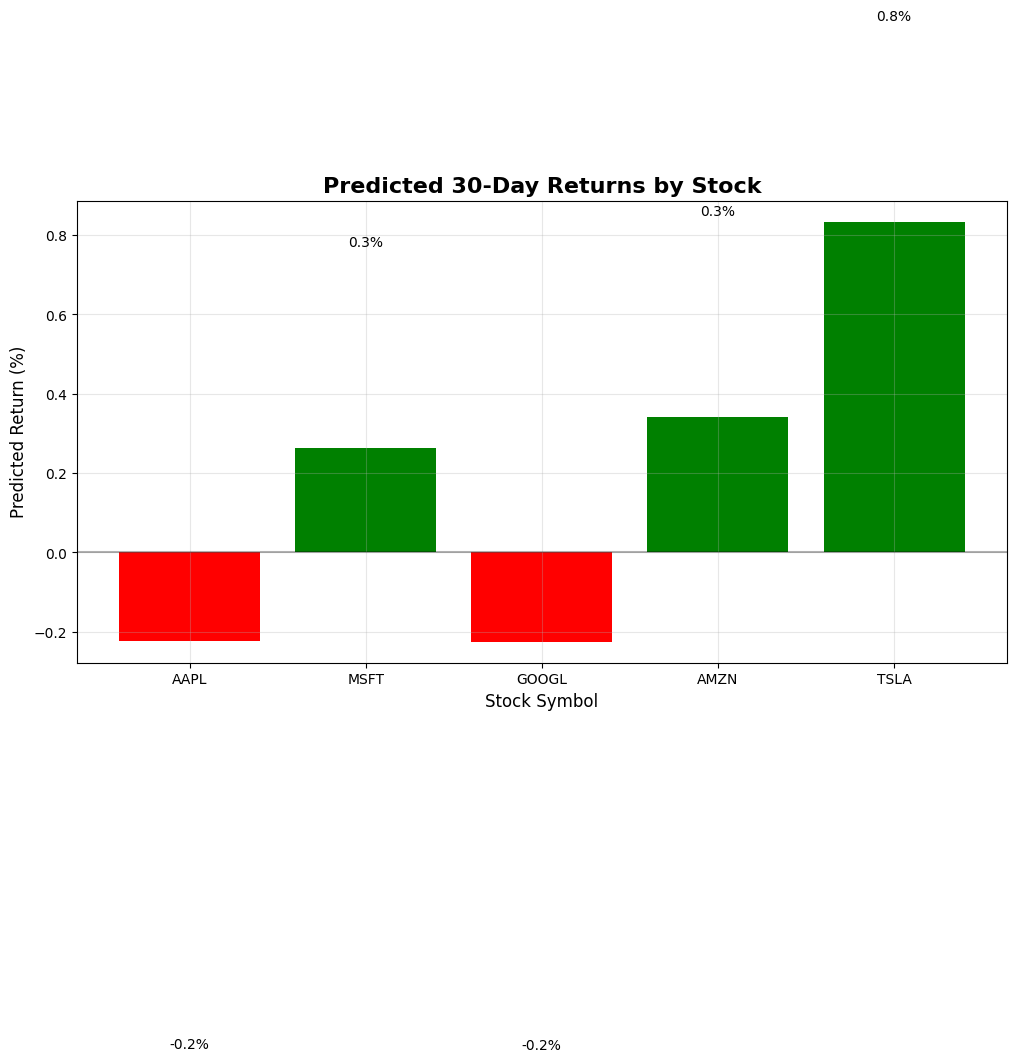


FORECAST STATISTICS:
Average predicted return: 0.20%
Best performer: TSLA (0.83%)
Worst performer: GOOGL (-0.22%)
Standard deviation: 0.40%

RISK ANALYSIS:
High volatility stocks: None
Moderate volatility stocks: None
Low volatility stocks: AAPL, MSFT, GOOGL, AMZN, TSLA


In [65]:
# Cell 12: Additional Analysis

if forecaster.forecasts:
    symbols_list = list(forecaster.forecasts.keys())
    returns_list = [forecaster.forecasts[symbol]['predicted_return'] for symbol in symbols_list]

    plt.figure(figsize=(12, 6))

    bars = plt.bar(symbols_list, returns_list, color=['green' if x > 0 else 'red' for x in returns_list])

    for bar, return_val in zip(bars, returns_list):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + (0.5 if height > 0 else -1),
                f'{return_val:.1f}%', ha='center', va='bottom' if height > 0 else 'top')

    plt.title('Predicted 30-Day Returns by Stock', fontsize=16, fontweight='bold')
    plt.xlabel('Stock Symbol', fontsize=12)
    plt.ylabel('Predicted Return (%)', fontsize=12)
    plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    print("\nFORECAST STATISTICS:")
    print("=" * 40)
    print(f"Average predicted return: {np.mean(returns_list):.2f}%")
    print(f"Best performer: {symbols_list[np.argmax(returns_list)]} ({max(returns_list):.2f}%)")
    print(f"Worst performer: {symbols_list[np.argmin(returns_list)]} ({min(returns_list):.2f}%)")
    print(f"Standard deviation: {np.std(returns_list):.2f}%")

    # Risk-Return Analysis
    print("\nRISK ANALYSIS:")
    print("=" * 40)
    high_risk = [s for s, r in zip(symbols_list, returns_list) if abs(r) > 10]
    moderate_risk = [s for s, r in zip(symbols_list, returns_list) if 5 <= abs(r) <= 10]
    low_risk = [s for s, r in zip(symbols_list, returns_list) if abs(r) < 5]

    print(f"High volatility stocks: {', '.join(high_risk) if high_risk else 'None'}")
    print(f"Moderate volatility stocks: {', '.join(moderate_risk) if moderate_risk else 'None'}")
    print(f"Low volatility stocks: {', '.join(low_risk) if low_risk else 'None'}")